# New York City Green Taxi Tip Prediction 
## Junkai Hu, Jingxi Chen, Amartya Banerjee


## Introduction:

write something to talk about the green taxi here.



For more information, read: 
https://en.wikipedia.org/wiki/Boro_taxi

In this project, we will perform stepwise data analysis on the dataset and try to explore the following things:
1. Collect the data and clean it.
2. Check the influence of payment type on tip report percentage.
3. Investigate the passenger tipping behavior by check the tip amount and tip percentage.
4. Study the correlation between tip amount and taxi time/date.
5. Analysis the trip distance and tip percentage.
6. Explore and visualize relationship between the pickup/drop-off location and tip percentage.
7. Calculate the average speed and study its influence on tip percentage.


## Required Tools

The following libraries are required for this project:
1. pandas
2. numpy
3. matplotlib
4. datetime
5. collections
6. seaborn
7. folium

In [46]:
!pip install folium

You are using pip version 9.0.3, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [47]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import datetime
import collections
import seaborn as sns
import folium
from folium.plugins import HeatMap
from folium.plugins import HeatMapWithTime

## Part 1 Data Collection

First we can find the direct link for the October 2017 NYC green taxi data by reading the html website source code (https://s3.amazonaws.com/nyc-tlc/trip+data/green_tripdata_%4d-%02d.csv). 

These data is collected from New York City Taxi and Limousine Commission website (http://www.nyc.gov/html/tlc/html/about/trip_record_data.shtml). 

Then we load the csv file into the panda dataframe. 

The data contains 1.6 M rows and 21 columns.

In [48]:
year, month = 2015, 12
url = "https://s3.amazonaws.com/nyc-tlc/trip+data/green_tripdata_%4d-%02d.csv" % (year,month)
raw_data = pd.read_csv(url)

In [49]:
raw_data.sample(5)

,VendorID,lpep_pickup_datetime,Lpep_dropoff_datetime,Store_and_fwd_flag,RateCodeID,Pickup_longitude,Pickup_latitude,Dropoff_longitude,Dropoff_latitude,Passenger_count,...,Fare_amount,Extra,MTA_tax,Tip_amount,Tolls_amount,Ehail_fee,improvement_surcharge,Total_amount,Payment_type,Trip_type
1039742,2,2015-12-19 23:46:22,2015-12-19 23:57:00,N,1,-73.961678,40.661983,-73.952209,40.678726,1,...,9.0,0.5,0.5,0.0,0.0,NaN,0.3,10.3,2,1.0
601220,2,2015-12-12 13:28:36,2015-12-12 13:41:10,N,1,-73.982735,40.695835,-73.892723,40.747189,1,...,20.0,0.0,0.5,3.0,0.0,NaN,0.3,23.8,1,1.0
63286,2,2015-12-02 12:55:19,2015-12-02 13:04:04,N,1,-73.958885,40.809975,-73.971397,40.795368,1,...,8.0,0.0,0.5,0.0,0.0,NaN,0.3,8.8,2,1.0
1263564,2,2015-12-24 13:36:37,2015-12-24 14:00:53,N,1,-73.896385,40.705441,-73.911308,40.707413,2,...,15.0,0.0,0.5,0.0,0.0,NaN,0.3,15.8,2,1.0
1322054,2,2015-12-25 15:12:33,2015-12-25 15:19:44,N,1,-73.916939,40.761406,-73.895561,40.768250,5,...,7.5,0.0,0.5,0.0,0.0,NaN,0.3,8.3,2,1.0


In [50]:
print("Number of rows: ", raw_data.shape[0],"\nNumber of columns: ", raw_data.shape[1])

Number of rows:  1608290 
Number of columns:  21


It contains variety information, such as pickup/drop-off date, time, and location, trip distance, fair amount in different subjects, and payment types.

The detailed explanation for the columns can be found at 
(http://www.nyc.gov/html/tlc/downloads/pdf/data_dictionary_trip_records_green.pdf)

In [51]:
raw_data.columns

Index(['VendorID', 'lpep_pickup_datetime', 'Lpep_dropoff_datetime',
       'Store_and_fwd_flag', 'RateCodeID', 'Pickup_longitude',
       'Pickup_latitude', 'Dropoff_longitude', 'Dropoff_latitude',
       'Passenger_count', 'Trip_distance', 'Fare_amount', 'Extra', 'MTA_tax',
       'Tip_amount', 'Tolls_amount', 'Ehail_fee', 'improvement_surcharge',
       'Total_amount', 'Payment_type', 'Trip_type '],
      dtype='object')

## Part 2 Data Processing


### 2.1 Invalide trip distance, location, and fare amount

After play around with data for a while, we found some wired staffs that might need to be clean. Here are some examples

In [52]:
df = raw_data.copy()

In [53]:
print ("The number of zero trip distance is:", df[df['Trip_distance'] == 0].shape[0])
print ("The percentage of zero trip distance is: %0.2f %%" %(df[df['Trip_distance'] == 0].shape[0] * 100.0/df.shape[0]))
print ("The number of negetive payment is:", df[df['Total_amount'] <= 0].shape[0])
print ("The percentage of negetive payment is: %0.2f %%" %(df[df['Total_amount'] <= 0].shape[0] * 100.0/df.shape[0]))
print ("The number of invalid pickup/dropoff location is:", df[(df['Pickup_longitude'] == 0) | (df['Pickup_latitude'] == 0)
    | (df['Dropoff_longitude'] == 0) | (df['Dropoff_latitude'] == 0)].shape[0])
print ("The percentage of invalid pickup/dropoff location is: %0.2f %%" %(df[(df['Pickup_longitude'] == 0)
    | (df['Pickup_latitude'] == 0) | (df['Dropoff_longitude'] == 0) | (df['Dropoff_latitude'] == 0)].shape[0] * 100.0/df.shape[0]))
print ("The total number of invalid entry is:", df[(df['Trip_distance'] == 0) | (df['Total_amount'] <= 0) | (df['Pickup_longitude'] == 0) 
    | (df['Pickup_latitude'] == 0) | (df['Dropoff_longitude'] == 0) | (df['Dropoff_latitude'] == 0)].shape[0])
print ("The percentage of total number of invalid entry is: %0.2f %%" %(df[(df['Trip_distance'] == 0) | (df['Total_amount'] <= 0)
    | (df['Pickup_longitude'] == 0) | (df['Pickup_latitude'] == 0) | (df['Dropoff_longitude'] == 0) | (df['Dropoff_latitude'] == 0)].shape[0] 
    * 100.0/df.shape[0]))

The number of zero trip distance is: 22041
The percentage of zero trip distance is: 1.37 %
The number of negetive payment is: 7289
The percentage of negetive payment is: 0.45 %
The number of invalid pickup/dropoff location is: 3835
The percentage of invalid pickup/dropoff location is: 0.24 %
The total number of invalid entry is: 29629
The percentage of total number of invalid entry is: 1.84 %


This corresponds to about 1.84% of the total data. Since this project is majorly studying the relationship between tip amount and fare amount, trip distance, and location. We can remove it without influence the general trend of the data.

We gona remove those invalid rows, and change the pickup/dropoff datetime into datetime format.

In [54]:
df = df[(df['Trip_distance'] > 0) | (df['Total_amount'] > 0) | (df['Pickup_longitude'] > 0) 
    | (df['Pickup_latitude'] > 0) | (df['Dropoff_longitude'] > 0) | (df['Dropoff_latitude'] > 0)]
df.shape

(1608117, 21)

In [55]:
datetime_cols = df.columns[1:3]
format_dt = "%Y-%m-%dT%H:%M:%S"
for col in datetime_cols:
    df[col] = pd.to_datetime(df[col], format = format_dt)
df.dtypes

VendorID                          int64
lpep_pickup_datetime     datetime64[ns]
Lpep_dropoff_datetime    datetime64[ns]
Store_and_fwd_flag               object
RateCodeID                        int64
Pickup_longitude                float64
Pickup_latitude                 float64
Dropoff_longitude               float64
Dropoff_latitude                float64
Passenger_count                   int64
Trip_distance                   float64
Fare_amount                     float64
Extra                           float64
MTA_tax                         float64
Tip_amount                      float64
Tolls_amount                    float64
Ehail_fee                       float64
improvement_surcharge           float64
Total_amount                    float64
Payment_type                      int64
Trip_type                       float64
dtype: object

From the log file, it seems that we only deleted a very small amount of data. The data is relatively clean. 

### 2.2 Influence of Payment type

In [56]:
print ("The total number of records is:", df.shape[0])
print ("The total number of zero tip is:", df[df['Tip_amount'] == 0.0].shape[0])
ratio = df[df['Tip_amount'] == 0.0].shape[0]/(0.0 + df.shape[0])
print ("The percentage of tip that is zero is: ", "{0:.2f}%".format(ratio * 100))

The total number of records is: 1608117
The total number of zero tip is: 952599
The percentage of tip that is zero is:  59.24%


Nearly 3 out of 5 trips did not pay tips, which is not reasonable based on our experience. Our guess is that the cash payers paid tips by cash and drivers did not report it. The following is the analysis of different payment types

In [57]:
tip0 = collections.Counter(df[df['Tip_amount'] == 0.0]['Payment_type'])
tipnot0 = collections.Counter(df[df['Tip_amount'] != 0.0]['Payment_type'])
name = {1: "credit card", 2: "Cash",3: "No charge",4: "Disputed Trip",5: "Unknown"}
print ("The breakdown of the trips by payment codes:")
for key in tip0:
    print ("When the payment code is ", "{:13s}".format(name[key]),',\
    the number of zero tip is: ', "{:6d}".format(tip0[key]),'. The number of non-zero tip is: ', tipnot0[key])

The breakdown of the trips by payment codes:
When the payment code is  Cash          ,    the number of zero tip is:  828368 . The number of non-zero tip is:  0
When the payment code is  credit card   ,    the number of zero tip is:  112805 . The number of non-zero tip is:  655487
When the payment code is  Disputed Trip ,    the number of zero tip is:    4977 . The number of non-zero tip is:  12
When the payment code is  No charge     ,    the number of zero tip is:    6360 . The number of non-zero tip is:  19
When the payment code is  Unknown       ,    the number of zero tip is:      89 . The number of non-zero tip is:  0


Our hypothesis is true. All of cash payers either did not pay tips or the drivers did not report them. This agrees with the description of the dataset (http://www.nyc.gov/html/tlc/downloads/pdf/data_dictionary_trip_records_green.pdf). The tip-amount field "is automatically populated for credit card tips. Cash tips are not included.". Notice that there are about 14.7% credit card payers who did not pay tips, which makes sense. In addition, the payment code of Disputed Trip, No charge, and Unknown also have very large percentage of zero tip (>99.7%), since they may also use cash as payment type, we will also get rid of these data as well. In conclusion, the only payment type that is trackable is the credit card users, so we will only analysis these specific data.

In [58]:
df = df[(df['Payment_type'] == 1)]
df.shape

(768292, 21)

## Part 3 Exploratory analysis & Data viz

Our hypothesis is that the tip percentage is not only depended on the trip fare, but also related to the trip date, trip time, trip origin/destination. Therefore, in this part, we will first analysis these variables.

First we will create a new column hour based on pickup day, time, and the day of week (Monday is 0, Sunday is 6). Then we can do some aggregation like mean and median distance by hour. 

In [59]:
df['day'] = df['lpep_pickup_datetime'].apply(lambda x: x.day)
df['hour'] = df['lpep_pickup_datetime'].apply(lambda x: x.hour)
df['weekday'] = df['lpep_pickup_datetime'].apply(lambda x: x.weekday())

In [60]:
df[['lpep_pickup_datetime', 'hour', 'day', 'weekday']].sample(10)

,lpep_pickup_datetime,hour,day,weekday
852289,2015-12-17 08:44:23,8,17,3
1063545,2015-12-20 09:58:05,9,20,6
545706,2015-12-11 17:37:15,17,11,4
187768,2015-12-04 19:09:58,19,4,4
552074,2015-12-11 19:05:03,19,11,4
1202344,2015-12-23 09:08:28,9,23,2
255859,2015-12-05 19:15:53,19,5,5
126451,2015-12-03 17:09:18,17,3,3
128370,2015-12-03 18:02:25,18,3,3
956186,2015-12-18 21:54:58,21,18,4


### 3.1 Build a derived variable for tip as a percentage of the total fare.

Next we will create a column "Tip percentage" which is the percentage of tip amount in total amount (including tip). For example, if the total fare is 100 dollars (including the tip) and the tip is 20 dollars. This percentage will give you 20.

In [61]:
df['total_without_tip'] = df['Total_amount'] - df['Tip_amount']
df['Tip_percentage'] = df['Tip_amount'] * 100 /df['total_without_tip']

In [62]:
df['Tip_percentage'].sample(10)

369244     19.936709
1029729    20.000000
1083318     0.000000
19397      19.417476
1415327     3.597122
1047312    14.705882
463687      0.000000
237958     25.060241
926240      0.000000
1079581    32.863850
Name: Tip_percentage, dtype: float64

From above sample, it seems that the tip percentage is more likely to be whole integer number, for example, 20% and 25%. In the next step we will build a histogram and check the distribution of tip percentage.

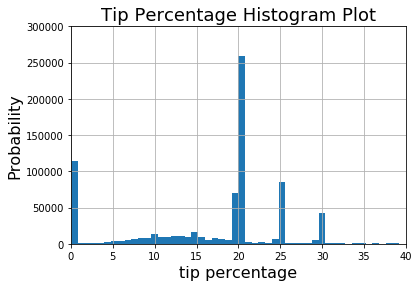

In [63]:
temp = df['Tip_percentage'].dropna()
temp = temp[temp < 40]
plt.hist(temp, bins = 50)
plt.xlabel('tip percentage', fontsize =16)
plt.ylabel('Probability',fontsize =16)
plt.title('Tip Percentage Histogram Plot',fontsize =18)
plt.axis([0, 40, 0, 300000])
plt.grid(True)
plt.savefig("figs/histogram_tip.png",dpi=100)
plt.show()
del temp

Except the expected 0% tip percentage, we also noticed huge peaks of modes in 20% tip, 25% tip and 30% tip. This is because passengers can press one of three values when they pay the driver.

Next question is: What is the relative likelihood that passengers would press one of these three ratios? 

In [64]:
total = df[df['Tip_amount'] != 0].shape[0]
tip20 = df[abs(df['Tip_percentage'] - 20.0) < 1].shape[0]  # 25% tip
tip25 = df[abs(df['Tip_percentage'] - 25.0) < 1].shape[0]   # 20% tip
tip30 = df[abs(df['Tip_percentage'] - 30.0) < 1].shape[0]  # 30% tip
print ("The total number of riders who payed tips are: ", total)
print ("The total number of riders who payed 20% tips are: ", tip20)
print ("The total number of riders who payed 25% tips are: ", tip25)
print ("The total number of riders who payed 30% tips are: ", tip30)
print ("The percentage of riders who used keypad to pay three three tips are: ","{0:.2f}%".format((tip20 + tip25 + tip30) /(df.shape[0] / 100.0)))

The total number of riders who payed tips are:  655487
The total number of riders who payed 20% tips are:  331341
The total number of riders who payed 25% tips are:  92687
The total number of riders who payed 30% tips are:  48191
The percentage of riders who used keypad to pay three three tips are:  61.46%


Therefore the ratios is roughly: 7:2:1 (20% : 25% : 30% tip), about 61.5% people will provide tip use these three values.

Are there any modes on the tip amount? Let us find it out.

/opt/conda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


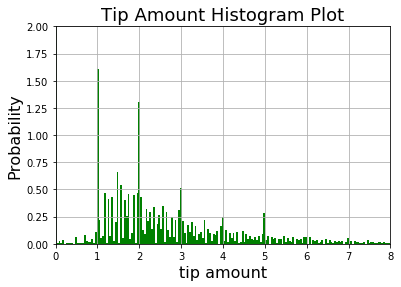

In [65]:
x = df[df['Tip_amount'] < 10]['Tip_amount']
n, bins, patches = plt.hist(x, 300, normed=1, facecolor='green')
plt.xlabel('tip amount', fontsize =16)
plt.ylabel('Probability', fontsize = 16)
plt.title('Tip Amount Histogram Plot',fontsize =18)
plt.axis([0, 8, 0, 2])
plt.grid(True)
plt.savefig("figs/tip_dollar.png",dpi =100)
del x

Notice there are clear peaks at 1, 2, 3, 4, and 5 dollars. How many are they?

In [66]:
tip1 = df[df['Tip_amount'] == 1.0].shape[0]   # 1 dollar tip
print ("The number of riders who paid 1 dollar as tip is: ", tip1)
tip2 = df[df['Tip_amount'] == 2.0].shape[0]   # 2 dollar tip
print ("The number of riders who paid 2 dollar as tip is: ", tip2)
tip3 = df[df['Tip_amount'] == 3.0].shape[0]   # 3 dollar tip
print ("The number of riders who paid 3 dollar as tip is: ", tip3)
tip4 = df[df['Tip_amount'] == 4.0].shape[0]   # 4 dollar tip
print ("The number of riders who paid 4 dollar as tip is: ", tip4)
tip5 = df[df['Tip_amount'] == 5.0].shape[0]   # 5 dollar tip
print ("The number of riders who paid 5 dollar as tip is: ", tip5)

The number of riders who paid 1 dollar as tip is:  52134
The number of riders who paid 2 dollar as tip is:  42324
The number of riders who paid 3 dollar as tip is:  16653
The number of riders who paid 4 dollar as tip is:  7324
The number of riders who paid 5 dollar as tip is:  9030


In [67]:
print ("The percentage of riders who tip integer amount is: ","{0:.2f}%".format((tip1 + tip2 + tip3 + tip4 + tip5) /(df.shape[0] / 100.0)))

The percentage of riders who tip integer amount is:  16.59%


The general picture is: 14.7% credit card papers either do not pay tips or the drivers took cash and did not report them. 61.5 % choose to press the button to pay 20%, 25% or 30% ( the ratio is roughly 7:2:1). Another 16.6 % will pay a rounded integer dollar (1, 2, 3, 4, 5 or 6 dollars). The majority paid 1 or 2 dollars. The rest of them (about 7%) may have same habit as me, who will pay the tip to make the total amount to an integer.

### 3.2 Pickup time.

In general, the tip persentage in the late night should be larger than in the noon, we will evaluate this hypothesis here.

In [68]:
import os
if not os.path.exists("figs"):
    os.makedirs("figs")

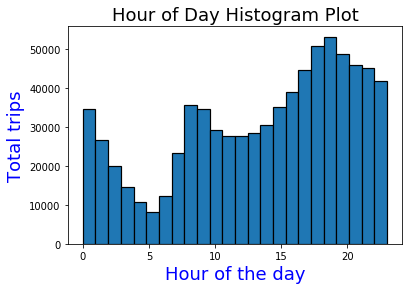

In [69]:
plt.hist(df['hour'], bins = 24, edgecolor='black', linewidth=1.2) 
plt.xlabel('Hour of the day', fontsize = 18, color ="b")
plt.ylabel('Total trips', fontsize = 18, color = "b")
plt.title('Hour of Day Histogram Plot',fontsize =18)
plt.savefig("figs/by_hour_trip_hist.png", dpi = 100)
plt.show()

From the figure we can see the trafic varies in the hour of day. There is a peak between 5 pm and 8 pm, which is the get off-work time. Interestingly, there is no corresponding peak in the morning. 5 am is a trough in the graph.

In the next step, we will plot and compare the tip percentage at different time of the day, different day in a week and month. And tried to find some clues from them.

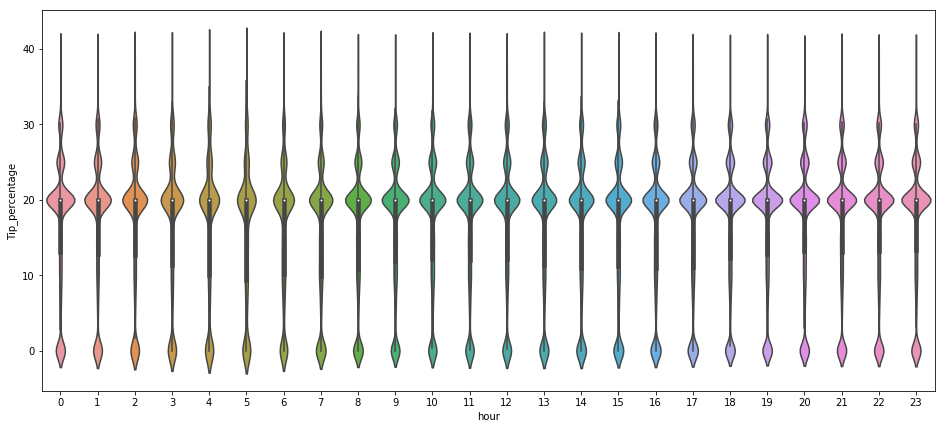

In [70]:
temp = df[df['Tip_percentage'] < 40]
plt.figure(figsize=(16,7))
sns.violinplot(x='hour',y='Tip_percentage',data=temp)
plt.savefig("figs/tip%_hour.png", dpi = 100)
del temp

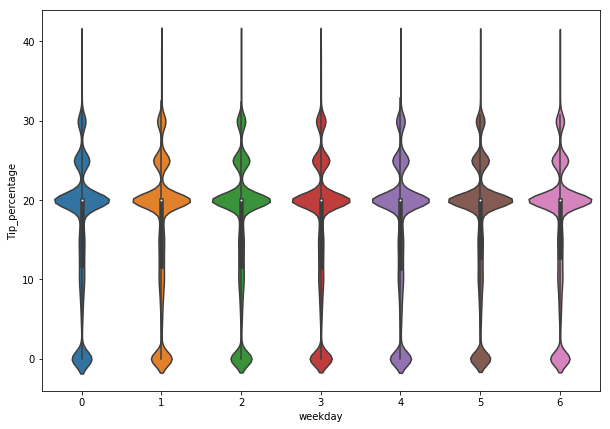

In [71]:
temp = df[df['Tip_percentage'] < 40]
plt.figure(figsize=(10,7))
sns.violinplot(x='weekday',y='Tip_percentage',data=temp)
plt.savefig("figs/tip%_weekday.png", dpi = 100)
del temp

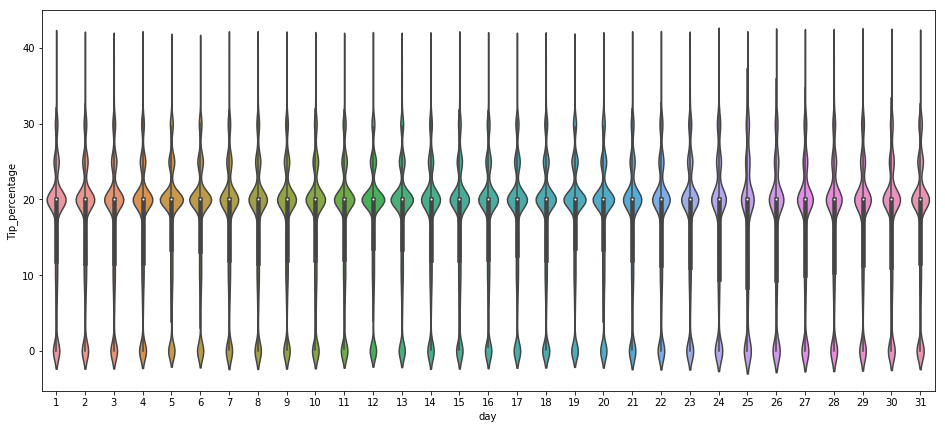

In [72]:
temp = df[df['Tip_percentage'] < 40]
plt.figure(figsize=(16,7))
sns.violinplot(x='day',y='Tip_percentage',data=temp)
plt.savefig("figs/tip%_weekday.png", dpi = 100)
del temp

From the figures, unlike what we expect, the tip percentage is neither related with hour of the day, nor related with the day in week. Even during Christmas and New Year's Eve, the tip percentage is similar as normal days.

### 3.3 Trip distance.

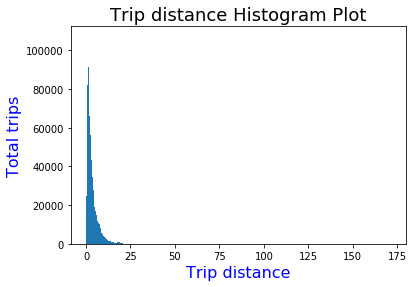

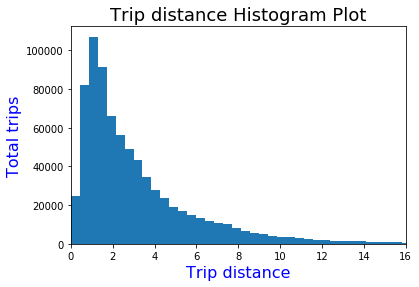

In [73]:
plt.figure()
plt.hist(df['Trip_distance'], bins = 400) 
plt.xlabel('Trip distance', fontsize = 16, color ="b")
plt.ylabel('Total trips', fontsize = 16, color = "b")
plt.title('Trip distance Histogram Plot',fontsize =18)
plt.savefig("figs/Trip_distance_hist.png", dpi = 100)
plt.figure()
plt.hist(df['Trip_distance'], bins = 400) 
plt.xlabel('Trip distance', fontsize = 16, color ="b")
plt.ylabel('Total trips', fontsize = 16, color = "b")
plt.title('Trip distance Histogram Plot',fontsize =18)
plt.savefig("figs/Trip_distance_hist2.png", dpi = 100)
plt.xlim(0,16)
plt.show()

The trip distance varies a lot, but will this parameter influence the tip amount?

Here we want to check if we need to include trip distance as one of the parameter for tip percentage.

In [74]:
distance_by_hour = df.groupby('hour')['Trip_distance'].agg([np.mean, np.median])
distance_by_hour

,mean,median
hour,,
0,3.273554,2.40
1,3.289055,2.42
2,3.388912,2.50
3,3.557267,2.64
4,4.268241,3.02
5,5.267751,3.80
6,5.070727,3.73
7,3.862702,2.69
8,3.367645,2.30


To visually observe the trend, we plot the median and mean average distance as the function of hour of the day.

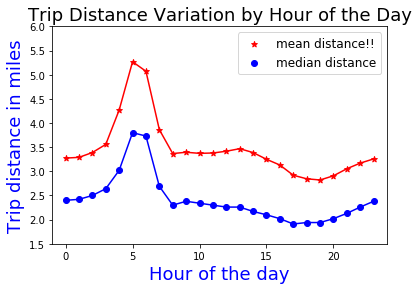

In [75]:
plt.scatter(range(24), distance_by_hour["mean"], c ='r',label = "mean distance!!", marker="*") 
plt.scatter(range(24), distance_by_hour['median'],c ='b',label = "median distance")
plt.plot(distance_by_hour['mean'],c ='r',label = "")
plt.plot(distance_by_hour['median'],c ='b',label = "")
legend = plt.legend(loc='upper right', fontsize='large')
plt.title('Trip Distance Variation by Hour of the Day',fontsize =18)
plt.axis([-1, 24, 1.5, 6])
plt.xlabel('Hour of the day', fontsize = 18, color ="b")
plt.ylabel('Trip distance in miles', fontsize = 18, color = "b")
plt.savefig("figs/by_hour_distance.png", dpi = 100)
plt.show()

From this figure, it seems there is a peak of the average/median travel distance before the morning rushing hour.

Compared with figure in 3.2, it seems that the trip distance is in reversely related with the number of rides in the hour of the day.

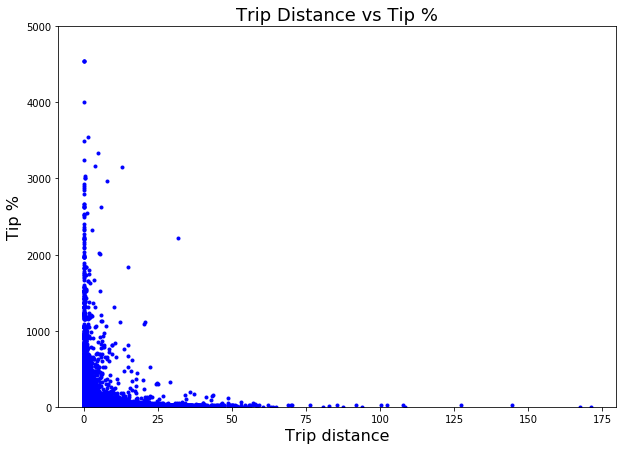

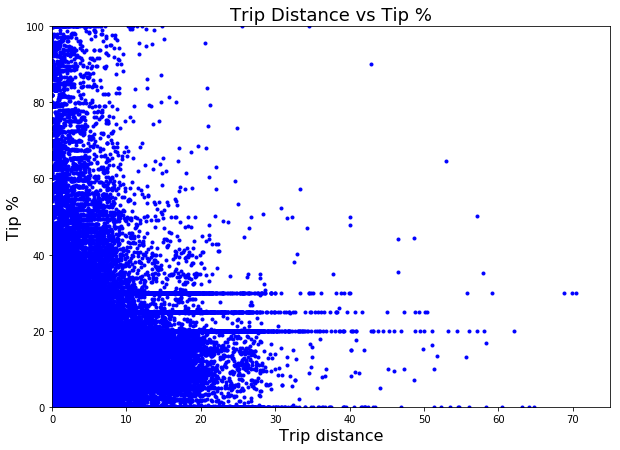

In [76]:
plt.figure(figsize=(10,7))
plt.scatter(df['Trip_distance'], df['Tip_percentage'], color = 'blue',marker='.')
plt.xlabel('Trip distance', fontsize =16)
plt.ylabel('Tip %', fontsize =16)
plt.title('Trip Distance vs Tip %',fontsize =18)
plt.ylim(0,5000)
plt.savefig("figs/tip %_distance.png",dpi = 100)
plt.figure(figsize=(10,7))
plt.scatter(df['Trip_distance'], df['Tip_percentage'], color = 'blue',marker='.')
plt.xlabel('Trip distance', fontsize =16)
plt.ylabel('Tip %', fontsize =16)
plt.title('Trip Distance vs Tip %',fontsize =18)
plt.ylim(0,100)
plt.xlim(0,75)
plt.savefig("figs/tip %_distance2.png",dpi = 100)
plt.show()

Long distance does not means a likely hood of higher tip %

### 3.4 Pickup/Dropoff location.

In [77]:
df2 = pd.DataFrame(pd.np.random.random(768292))
df_elements = df2.sample(frac=0.02)
df_rest = df2.loc[df2.index.isin(df_elements.index)]

In [78]:
lat = np.array(df["Pickup_latitude"][0:len(df)])
long = np.array(df["Pickup_longitude"][0:len(df)])
data1 = [[lat[i],long[i]] for i in range(len(df_rest))]
map_osm = folium.Map(location=[40.77, -73.84], zoom_start=11)
map_osm.add_child(HeatMap(data=data1, radius=10, gradient={.25: 'blue', .5: 'green', 0.75: 'yellow', 1: 'red'}))
map_osm

In [79]:
lat = np.array(df["Dropoff_latitude"][0:len(df)])
long = np.array(df["Dropoff_longitude"][0:len(df)])
data1 = [[lat[i],long[i]] for i in range(len(df_rest))]
map_osm = folium.Map(location=[40.77, -73.84], zoom_start=11)
map_osm.add_child(HeatMap(data=data1, radius=10, gradient={.25: 'blue', .5: 'green', 0.75: 'yellow', 1: 'red'}))
map_osm

From the heat map, most of the trips are pick up around (but not include) the Manhattan downtown, and dropoff at Manhattan downtown, Brooklyn, and LGA & JFK airports. This is because Green taxis in New York City are only allowed to pick up passengers in outer boroughs (excluding JFK and LGA Airports unless arranged in advance) and in Manhattan above East 96th and West 110th Streets. However, they can drop passengers off anywhere, but will not be able to pick up new passengers out of the above zone. 

This makes us curious whether the passengers will tip more when their destination will be JFK or LGA airport, because they have more luggage and may know that the Green taxi cannot pick up new passengers in the airport.


In [80]:
LGA_taxi = pd.DataFrame()
terminals = ["A", "B", "C", "D"]
colors = ["red",'blue','green','yellow']
LGA = [[40.772562, -73.885640], [40.773893, -73.872204],[40.769722, -73.864659],[40.768702, -73.862036]]  #LGA terminal coordinates
for i in range(len(LGA)):
    temp1 = df[(abs(df["Dropoff_latitude"] - LGA[i][0]) < 0.003) & (abs(df["Dropoff_longitude"] - LGA[i][1]) < 0.002)]
    LGA_taxi = LGA_taxi.append(temp1)

LGA_count = LGA_taxi.shape[0]
LGA_avg_distance = np.mean(LGA_taxi['Trip_distance'])
LGA_avg_tip = np.mean(LGA_taxi['Tip_amount'])
LGA_avg_tip_per = np.mean(LGA_taxi[LGA_taxi['Tip_percentage'] < 1000]['Tip_percentage'])

In [81]:
JFK = [40.646, -73.784]  #JFK terminal coordinates
Dropoff_at_JFK = df[(abs(df["Dropoff_latitude"] - JFK[0]) < 0.008) & (abs(df["Dropoff_longitude"] - JFK[1]) < 0.01)]
JFK_taxi = Dropoff_at_JFK
JFK_count = JFK_taxi.shape[0]
JFK_avg_distance = np.mean(JFK_taxi['Trip_distance'])
JFK_avg_tip = np.mean(JFK_taxi['Tip_amount'])
JFK_avg_tip_per = np.mean(JFK_taxi[JFK_taxi['Tip_percentage'] < 1000]['Tip_percentage'])

In [82]:
NYC_count = df.shape[0]
NYC_avg_distance = np.mean(df['Trip_distance'])
NYC_avg_tip = np.mean(df['Tip_amount'])
NYC_avg_tip_per = np.mean(df[df['Tip_percentage'] < 1000]['Tip_percentage'])

To compare airport taxi data with general city data, we made a bar plots to compare the tips among JFK, LGA and general city traffic.

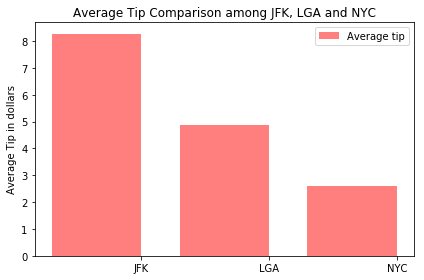

In [83]:
index = np.arange(3)
bar_width = 0.7
opacity = 0.5
rects1 = plt.bar(range(3), (JFK_avg_tip,LGA_avg_tip,NYC_avg_tip), bar_width, alpha=opacity, color='r', label='Average tip')
plt.ylabel('Average Tip in dollars')
plt.title('Average Tip Comparison among JFK, LGA and NYC')
plt.xticks(index + 0.5* bar_width, ('JFK', 'LGA', 'NYC'))
plt.legend()
plt.tight_layout()
plt.savefig("figs/average_tip.png")
plt.show()

The tip amount is JFK > LGA > NYC, probably due to the average trip distance is JFK > LGA > NYC. Since JFK airport is farther away from the city, and most of trips are from area around the Manhattan downtown to the Manhattan/Brooklyn, which is short.

Next we want to check the tip % difference.

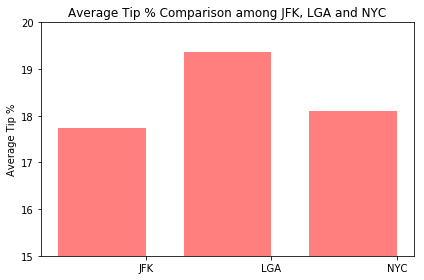

In [84]:
index = np.arange(3)
bar_width = 0.7
opacity = 0.5
rects1 = plt.bar(range(3), (JFK_avg_tip_per,LGA_avg_tip_per,NYC_avg_tip_per), bar_width, alpha=opacity, color='r')
plt.ylabel('Average Tip %')
plt.title('Average Tip % Comparison among JFK, LGA and NYC')
plt.xticks(index + 0.5* bar_width, ('JFK', 'LGA', 'NYC'))
plt.ylim(15, 20)
plt.tight_layout()
plt.savefig("figs/average_tip%.png")
plt.show()

The tip % are all around 18.5 %, which is in agree of our previous found that most of passengers pay 20 % tip, there are slightly difference between locations, and we may investigate it further in the modeling part.

Continuous with last part, we are further wondering the tip % difference at different pick-up and drop-off locations. Here we had drawn two tip percentage heat maps.

We firstly divide the locations into small blocks. Then we calculate the median tip% in different blocks use pandas groupby method. The heat map is derived from the tip% in different locations.

In [116]:
df['pick_lat'] = df['Pickup_latitude'] * 500 // 1 / 500
df['pick_long'] = df['Pickup_longitude'] * 500 // 1 / 500
df['drop_lat'] = df['Dropoff_latitude'] * 500 // 1 / 500
df['drop_long'] = df['Dropoff_longitude'] * 500 // 1 / 500
df.sample(5)

,VendorID,lpep_pickup_datetime,Lpep_dropoff_datetime,Store_and_fwd_flag,RateCodeID,Pickup_longitude,Pickup_latitude,Dropoff_longitude,Dropoff_latitude,Passenger_count,...,weekday,total_without_tip,Tip_percentage,trip_time_in_minutes,speed,speed_round,pick_lat,pick_long,drop_lat,drop_long
64280,2,2015-12-02 12:51:44,2015-12-02 13:22:24,N,1,-73.959801,40.808594,-73.969093,40.761719,2,...,2,20.8,19.230769,30.666667,7.845652,5.0,40.808,-73.960,40.760,-73.970
1561700,2,2015-12-31 14:38:11,2015-12-31 14:49:33,N,1,-73.977188,40.681335,-73.980568,40.660431,1,...,3,10.3,20.000000,11.366667,10.029326,10.0,40.680,-73.978,40.660,-73.982
787246,2,2015-12-15 22:33:46,2015-12-15 22:47:50,N,1,-73.980392,40.676483,-73.951431,40.714027,1,...,1,16.3,20.000000,14.066667,17.232227,15.0,40.676,-73.982,40.714,-73.952
1231616,2,2015-12-23 19:47:02,2015-12-23 21:01:23,N,1,-73.978561,40.684425,-74.028343,40.623070,1,...,2,47.8,20.000000,74.350000,4.180229,0.0,40.684,-73.980,40.622,-74.030
917276,2,2015-12-18 10:36:26,2015-12-18 10:52:28,N,1,-73.939201,40.805580,-73.962135,40.779202,1,...,4,12.8,20.000000,16.033333,8.607069,5.0,40.804,-73.940,40.778,-73.964


#### Pickup location tip heat map 

In [106]:
tip_pick = df[df['Tip_percentage'] <= 100].groupby(['pick_lat', 'pick_long']).median()
tip_pick.sample()

,,VendorID,RateCodeID,Pickup_longitude,Pickup_latitude,Dropoff_longitude,Dropoff_latitude,Passenger_count,Trip_distance,Fare_amount,Extra,...,day,hour,weekday,total_without_tip,Tip_percentage,trip_time_in_minutes,speed,speed_round,drop_lat,drop_long
pick_lat,pick_long,,,,,,,,,,,,,,,,,,,,,
40.674,-73.916,2.0,1.0,-73.915619,40.674238,-73.915909,40.674177,1.0,5.7,28.25,0.0,...,17.0,16.0,3.0,29.3,24.99693,29.1,11.838613,10.0,40.674,-73.916


In [131]:
temp = tip_pick['Tip_percentage']
data1 = [[temp.index[i][0], temp.index[i][1], temp[i]] for i in range(len(temp))]
map_osm = folium.Map(location=[40.77, -73.84], zoom_start=11)
map_osm.add_child(HeatMap(data=data1, radius=3, gradient={.07: 'blue', .14: 'green', 0.21: 'yellow', .28: 'red'}))
del temp
map_osm

#### Drop-off location tip heat map 

In [130]:
tip_drop = df[df['Tip_percentage'] <= 100].groupby(['drop_lat', 'drop_long']).median()
temp = tip_drop['Tip_percentage']
temp
data1 = [[temp.index[i][0], temp.index[i][1], temp[i]] for i in range(len(temp))]
map_osm = folium.Map(location=[40.77, -73.84], zoom_start=11)
map_osm.add_child(HeatMap(data=data1, radius=3, gradient={.07: 'blue', .14: 'green', 0.21: 'yellow', .28: 'red'}))
del temp
map_osm

There are some tip% difference in different pickup/drop-off location.

### 3.5 Average speed over the course of a trip

We thought that if the speed is faster, then the passenger might be more satisfied about the trip and tip more, so here we want to check if the speed influence the tip.

First we rebuild the data and calculate the average speed (in miles per hour) for each trip.

In [85]:
df['trip_time_in_minutes'] = (df['Lpep_dropoff_datetime']- df['lpep_pickup_datetime']).apply(lambda x: x.total_seconds())/60.0
df['speed'] = df['Trip_distance'] / (df['trip_time_in_minutes']/60.0)
df['speed_round'] = df['speed'] // 5 * 5

The median speed is 12.04 mph


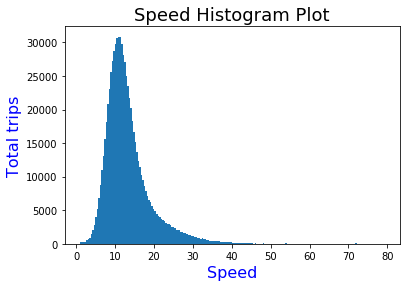

In [86]:
temp = df[(df['speed'] < 80) & (df['speed'] > 1)]
plt.hist(temp['speed'], bins = 200) 
plt.xlabel('Speed', fontsize = 16, color ="b")
plt.ylabel('Total trips', fontsize = 16, color = "b")
plt.title('Speed Histogram Plot',fontsize =18)
plt.savefig("figs/Speed_hist.png", dpi = 100)
median_speed = np.median(temp['speed'])
print("The median speed is %.2f mph" %(median_speed))
del temp

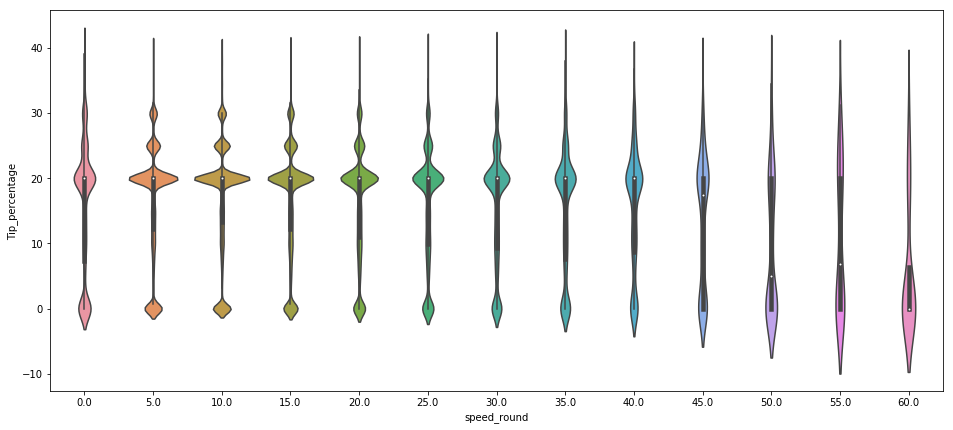

In [87]:
temp = df[(df['speed'] <= 60) & (df['speed'] > 1) & (df['Tip_percentage'] < 40)]
plt.figure(figsize=(16,7))
sns.violinplot(x='speed_round',y='Tip_percentage',data=temp)
plt.savefig("figs/tip%_speed_round.png", dpi = 100)
del temp

The distribution of the tip% do varies at different speed. Interestingly, the faster the speed, the less likelihood the passenger will pay higher tip. Probably because the higher speed trips normally are long distance and cost higher basic fare.